In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_spec_table import show_circuit, summary_penny
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
[ds] = qml.data.load("ketgpt")

In [ ]:
q = []
g = []
d = []
for seed in range(len(ds.circuits)): # qubit, gate count, depth
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            qml.apply(op)
        return qml.state()

    obj = qml.specs(circuit)()['resources']
    q.append(obj.num_wires)
    g.append(obj.num_gates)
    d.append(obj.depth)

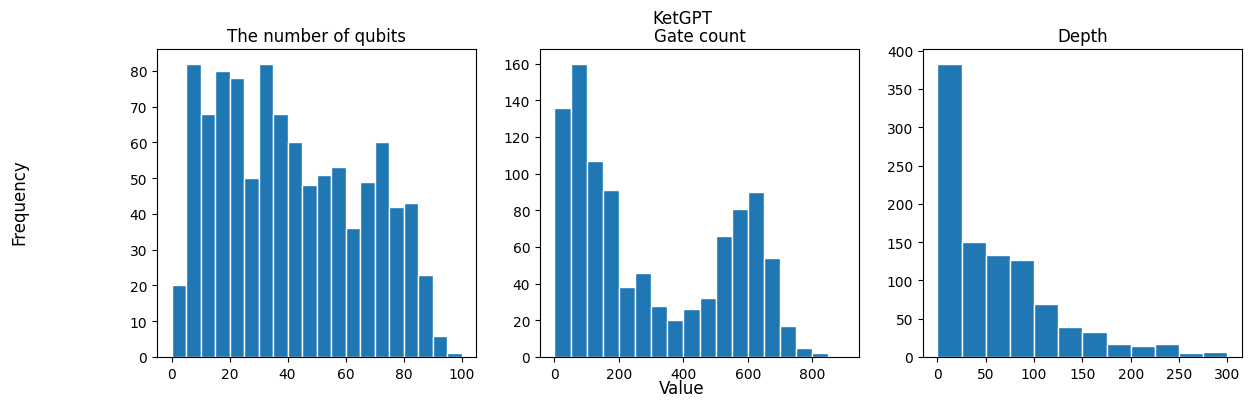

In [30]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
for idx, elem in enumerate([q, g, d]):
    if idx == 0:
        axs[idx].hist(elem, bins=np.arange(0, 101,5), edgecolor='white')
        axs[idx].set_title('The number of qubits')
    elif idx ==1:
        axs[idx].hist(elem, bins=np.arange(0, 901,50), edgecolor='white')
        axs[idx].set_title('Gate count')
    else:
        axs[idx].hist(elem, bins=np.arange(0, 301,25), edgecolor='white')
        axs[idx].set_title('Depth')
fig.supxlabel('Value')
fig.supylabel('Frequency')
fig.suptitle('KetGPT')
plt.show()

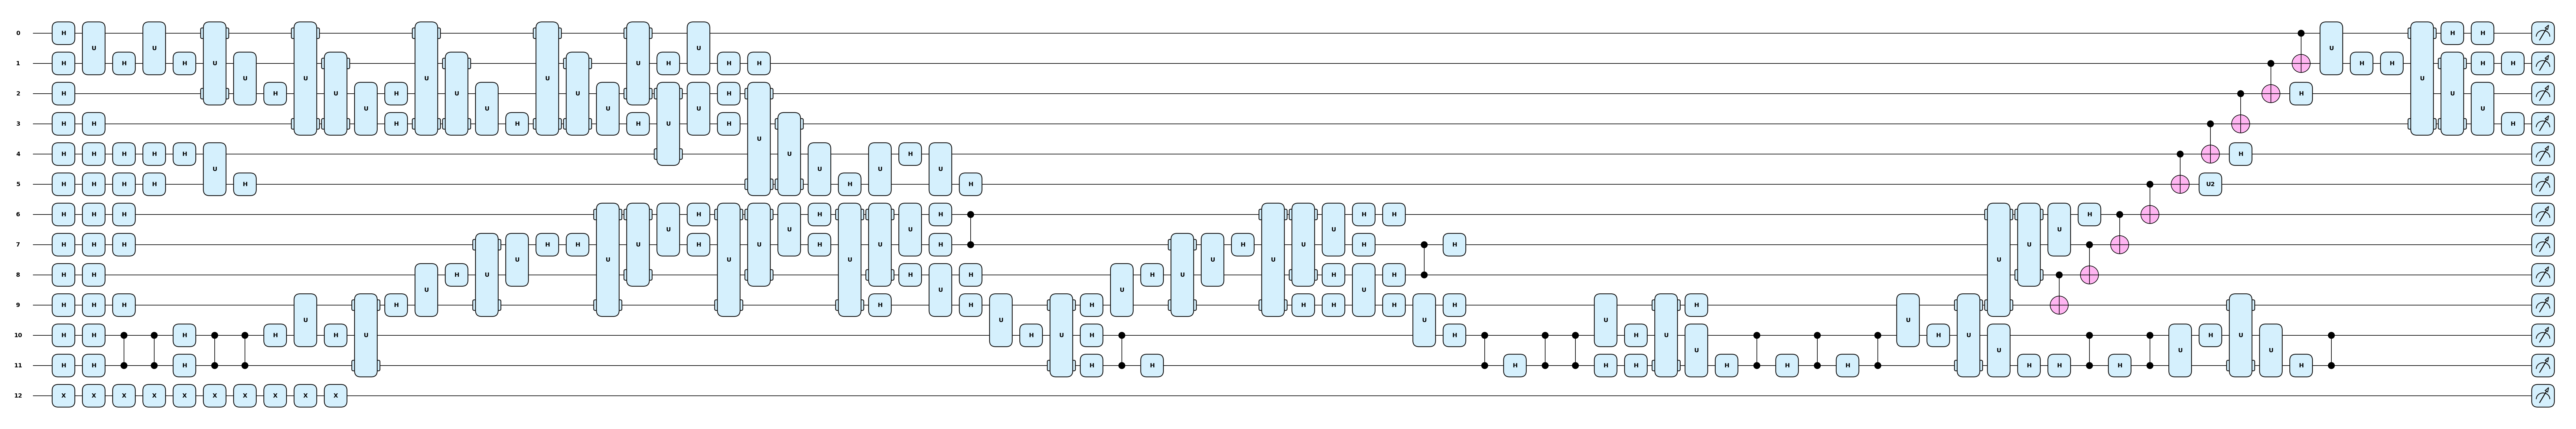

c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)


,original,qiskit,penny,mine
qubits,12,12,12,12
gates,146,144,145,144
1q gates,63,61,61,61
2q gates,19,19,19,19
unitary,64,64,64,64
depth,60,67,60,59


In [4]:
# example
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

show_circuit(circuit)

qnode_q1, df = optimization_level_1(circuit)
qnode_q2 = optimization_level_2(qnode_q1)
qnode_q1, df = optimization_level_1(qnode_q2)
df

In [ ]:
dfs = []
missing = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            qml.apply(op)
        return qml.state()
    obj = qml.specs(circuit)()['resources']
    try:
        qnode_q1, df = optimization_level_1(circuit)
        qnode_q2 = optimization_level_2(qnode_q1)
        qnode_q1, df = optimization_level_1(qnode_q2)
        dfs.append(df)
    except:
        missing.append(seed)
        pass

In [6]:
len(dfs)

363

In [7]:
dfs[0]

,original,qiskit,penny,mine
qubits,12,12,12,12
gates,146,144,145,144
1q gates,63,61,61,61
2q gates,19,19,19,19
unitary,64,64,64,64
depth,60,67,60,59


In [8]:
dfs_ratio = []
for idx, df in enumerate(dfs):
    df.drop(['qubits'], axis='index', inplace=True)
    df.drop(['unitary'], axis='index', inplace=True)
    df = df.rename(columns={'qiskit':'Qiskit', 'penny':'PennyLane', 'mine':'HomoGO'},
                             index={'gates': 'Gate count', 'depth': 'Depth'})
    dfs_ratio.append(df.div(df['original'], axis=0).round(3))

dfs_ratio[0]

,original,Qiskit,PennyLane,HomoGO
Gate count,1.0,0.986,0.993,0.986
1q gates,1.0,0.968,0.968,0.968
2q gates,1.0,1.000,1.000,1.000
Depth,1.0,1.117,1.000,0.983


In [9]:
dfs_ratio = [df.drop(columns='original') for df in dfs_ratio]

records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

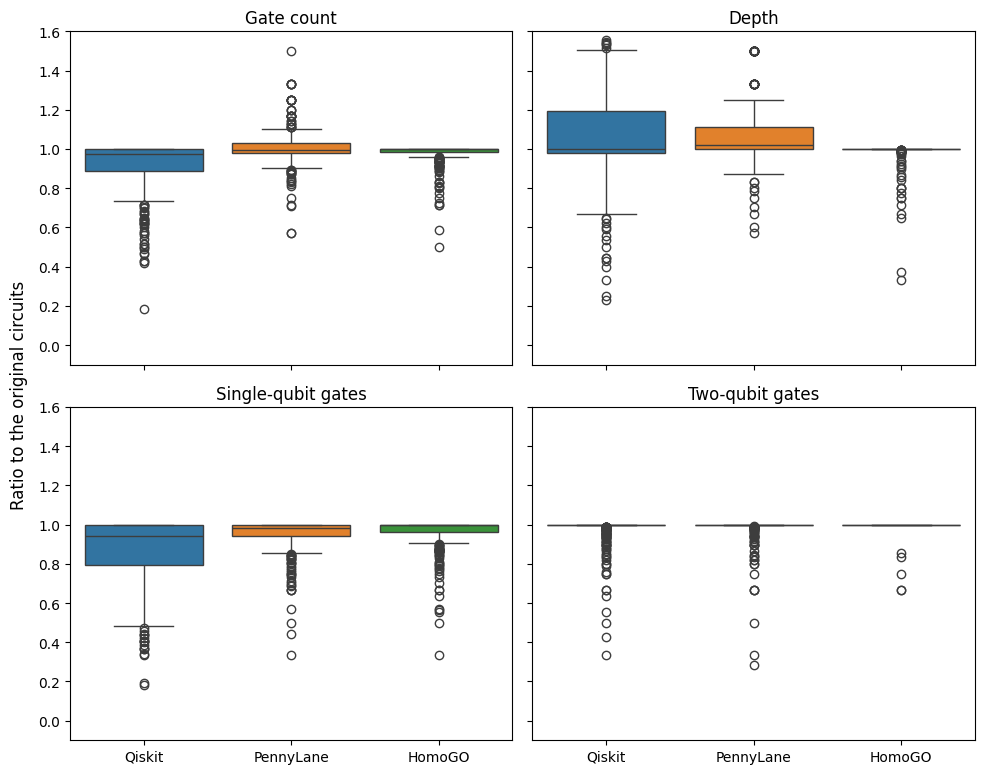

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for i, metric in enumerate(['Gate count', 'Depth', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Depth')
    elif i==2:
        ax.set_title('Single-qubit gates')
    elif i==3:
        ax.set_title('Two-qubit gates')
    ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label
    # ax.set_xticklabels([custom_labels[m] for m in order])

# fig.legend(handles, labels, loc='upper center', ncol=3, title='Method')
fig.supylabel('Ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

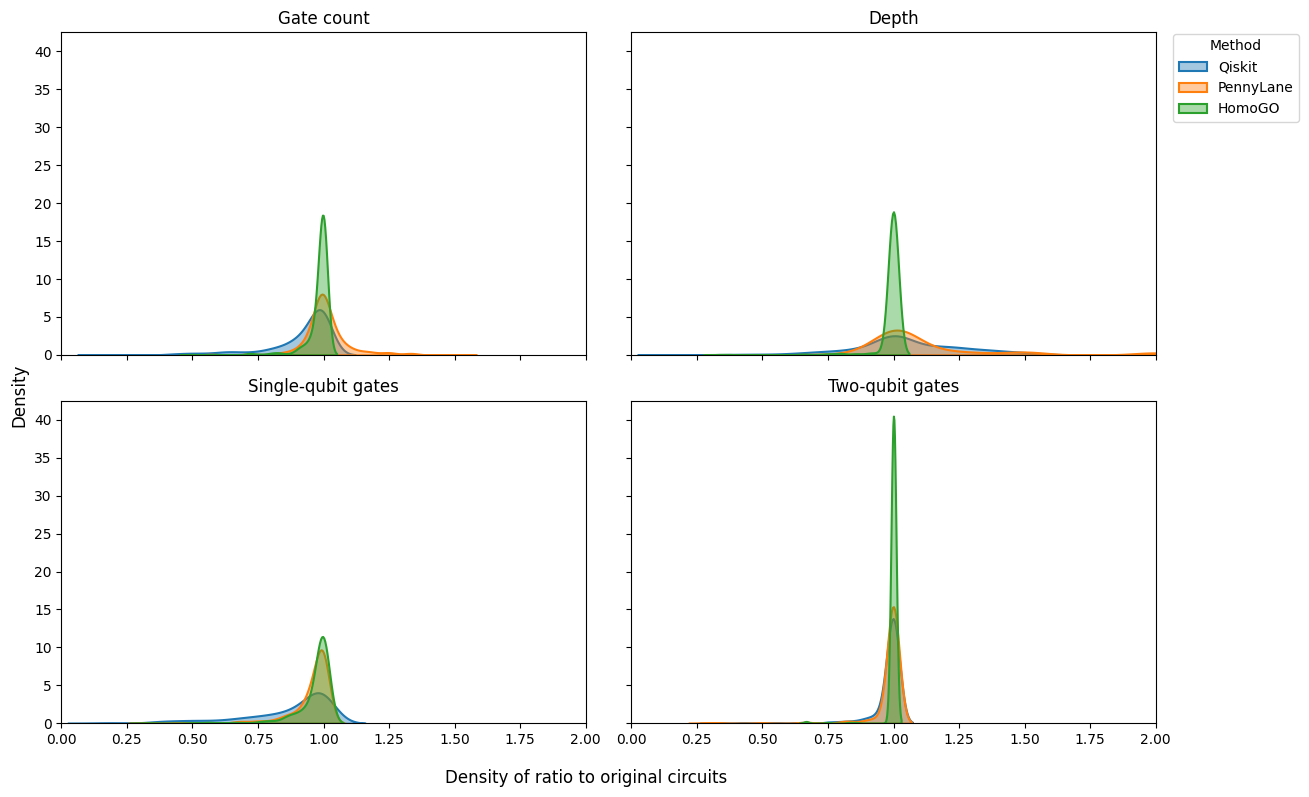

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

palette = {'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'}
methods = long_df['method'].unique()

for i, metric in enumerate(['Gate count', 'Depth', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]

    for method in methods:
        method_data = subset[subset['method'] == method]['ratio']
        sns.kdeplot(method_data, ax=ax, label=method, fill=True, alpha=0.4, linewidth=1.5, color=palette[method])

    titles = ['Gate count', 'Depth', 'Single-qubit gates', 'Two-qubit gates']
    ax.set_title(titles[i])
    ax.set_xlim(0, 2)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Place legend outside the plot (upper right)
fig.legend(
    labels=methods,
    loc='upper right',
    bbox_to_anchor=(1.1, 0.96),
    title='Method'
)

fig.supxlabel('Density of ratio to original circuits')
fig.supylabel('Density')
plt.tight_layout()
plt.show()

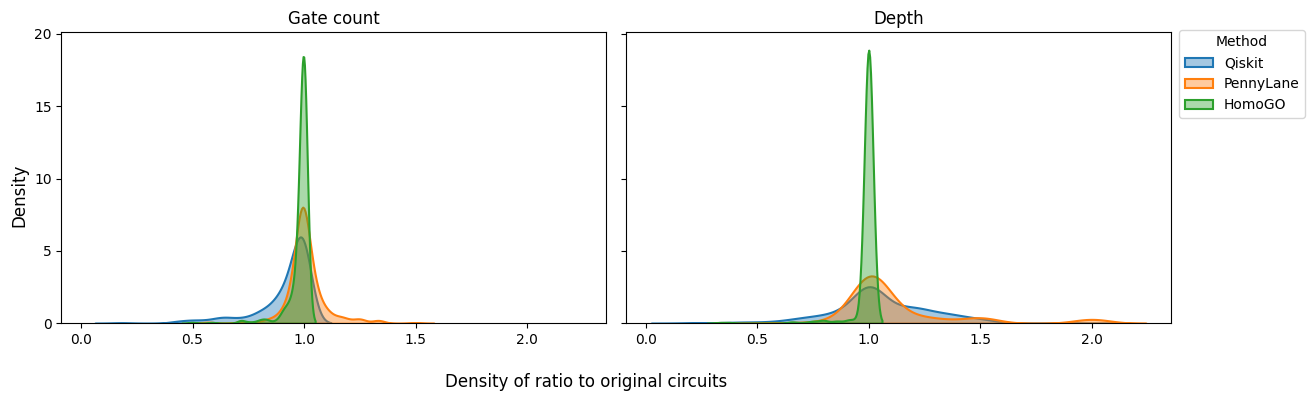

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

palette = {'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'}
metrics_to_plot = ['Gate count', 'Depth']
methods = long_df['method'].unique()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    subset = long_df[long_df['metric'] == metric]

    for method in methods:
        method_data = subset[subset['method'] == method]['ratio']
        sns.kdeplot(method_data, ax=ax, label=method, fill=True, alpha=0.4, linewidth=1.5, color=palette[method])

    ax.set_title(metric)
    ax.set_ylim(0, 20.1)
    ax.set_yticks(np.arange(0,21,5))
    ax.set_xlabel('')
    ax.set_ylabel('')

# External legend (upper right)
fig.legend(
    labels=methods,
    loc='upper right',
    bbox_to_anchor=(1.105, 0.93),
    title='Method'
)

fig.supxlabel('Density of ratio to original circuits')
fig.supylabel('Density')
plt.tight_layout()
plt.show()

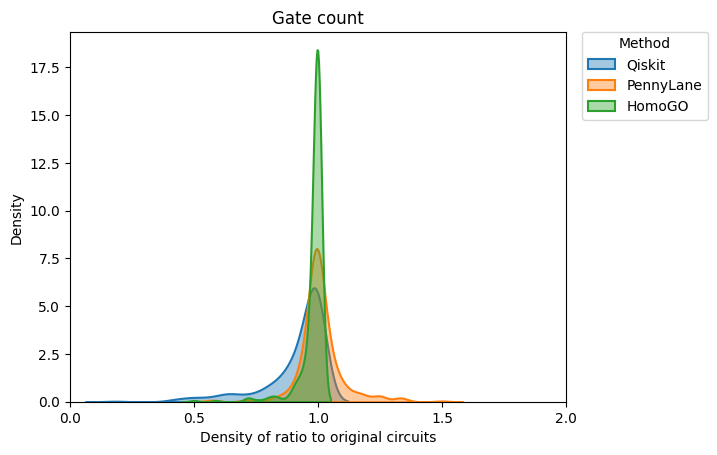

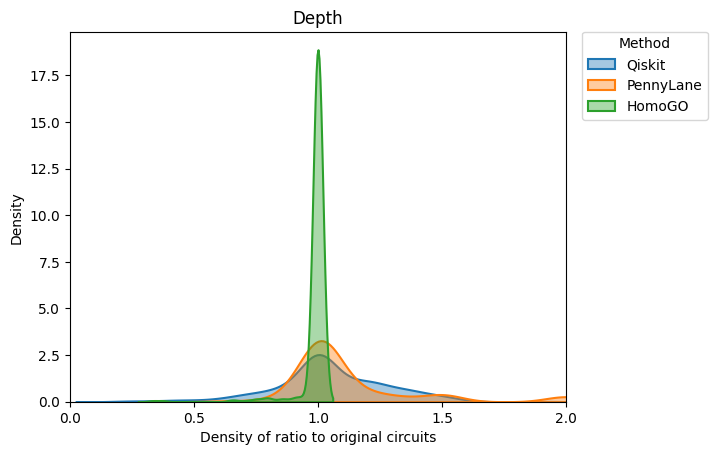

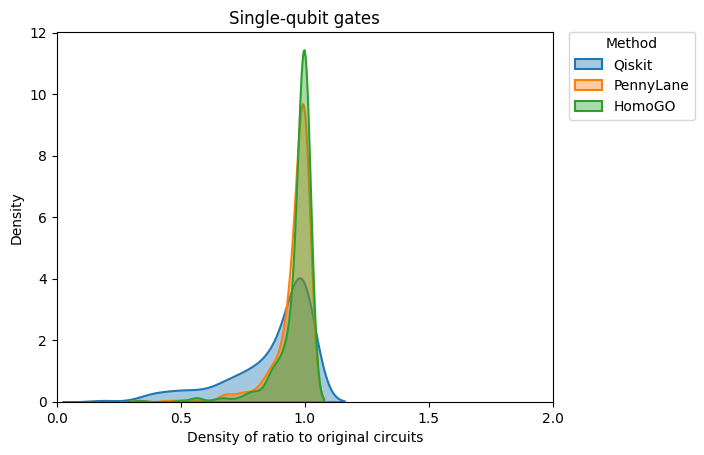

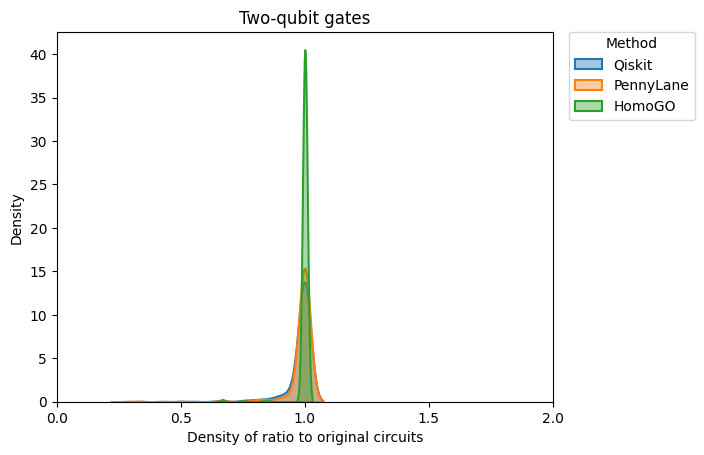

In [85]:
palette = {'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'}
methods = long_df['method'].unique()

for i, metric in enumerate(['Gate count', 'Depth', '1q gates', '2q gates']):
    subset = long_df[long_df['metric'] == metric]

    for method in methods:
        method_data = subset[subset['method'] == method]['ratio']
        sns.kdeplot(method_data,label=method, fill=True, alpha=0.4, linewidth=1.5, color=palette[method])

    titles = ['Gate count', 'Depth', 'Single-qubit gates', 'Two-qubit gates']
    plt.title(titles[i])
    plt.xlim(0, 2)
    plt.xlabel('Density of ratio to original circuits')
    plt.xticks(np.arange(0,2.1,0.5))
    plt.ylabel('Density')
    plt.legend(labels=methods, loc='upper right', bbox_to_anchor=(1.3, 1.02), title='Method')
    plt.show()

In [25]:
dfs_ratio[4]

,Qiskit,PennyLane,HomoGO
Gate count,0.986,1.002,1.0
1q gates,0.949,1.000,1.0
2q gates,1.000,1.000,1.0
Depth,1.347,1.005,1.0


In [20]:
stats_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()
stats_df.columns = ['Metric', 'Method', 'Average Ratio']
stats_df['Average Ratio'] = (1-stats_df['Average Ratio'])*100
stats_df

,Metric,Method,Average Ratio
0,HomoGO,1q gates,3.771350
1,HomoGO,2q gates,0.360588
2,HomoGO,Depth,1.307163
3,HomoGO,Gate count,2.097796
4,PennyLane,1q gates,4.801102
5,PennyLane,2q gates,1.840588
6,PennyLane,Depth,-11.949311
7,PennyLane,Gate count,-0.707163
8,Qiskit,1q gates,13.285124
9,Qiskit,2q gates,2.474412


In [16]:
long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()

,method,metric,mean
0,HomoGO,1q gates,0.962287
1,HomoGO,2q gates,0.996394
2,HomoGO,Depth,0.986928
3,HomoGO,Gate count,0.979022
4,PennyLane,1q gates,0.951989
5,PennyLane,2q gates,0.981594
6,PennyLane,Depth,1.119493
7,PennyLane,Gate count,1.007072
8,Qiskit,1q gates,0.867149
9,Qiskit,2q gates,0.975256


In [28]:
min_df = long_df.groupby(['method','metric'])['ratio'].agg(['min']).reset_index()
min_df['min'] = (1-min_df['min'])*100
min_df

,method,metric,min
0,HomoGO,1q gates,66.7
1,HomoGO,2q gates,33.3
2,HomoGO,Depth,66.7
3,HomoGO,Gate count,50.0
4,PennyLane,1q gates,66.7
5,PennyLane,2q gates,71.4
6,PennyLane,Depth,42.9
7,PennyLane,Gate count,42.9
8,Qiskit,1q gates,81.8
9,Qiskit,2q gates,66.7
